# Overview
This file serves to recreate, with some adjustments, our work from last semester with new audio samples. We extract 8 total features from the .wav files:
* Autocorrelation Coefficient (ACC): measures the linear relation between an observation at sample N and the observations at previous samples 
* Zero Crossing Rate (ZCR): the rate at which a signal changes from positive to zero to negative or from negative to zero to positive
* Temporal Entropy (Ht): The entropy of an audio signal is a measure of energy dispersion. In the temporal domain, values below 0.7 indicate a brief concentration of energy (few miliseconds), while values close 1 indicate low concentration of energy, no peaks, smooth and constant background noise.
* Spectral Entropy (Hf): Compute different entropies based on the average spectrum, its variance, and its maxima
* Acoustic Complexity Index (ACI): contrasts the amplitude difference between one short time step (e.g. 0.03 s) and the next, within a narrow frequency band (e.g. 62 Hz)
* Spectral Cover (SC)
  * LFC: Proportion of the LF bandwidth of the spectrogram with activity above the threshold.
  * MFC: Proportion of the MF bandwidth of the spectrogram with activity above the threshold.
  * HFC: Proportion of the HF bandwidth of the spectrogram with activity above the threshold.

Using these features, we also implement the following models:
* Support Vector Machine (SVM)
* Random Forests (RF)
* XGBoost (XGB)

In [1]:
import librosa
import librosa.display
import librosa.feature
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn import metrics
from sklearn.model_selection import LeaveOneOut, train_test_split, KFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import maad
from maad.features import temporal_entropy
from micromlgen import port 
import scipy
from scipy import signal
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns

ModuleNotFoundError: No module named 'statsmodels'

### Main function

In [56]:
def main():
    # Locate all audio files from new testing samples folder
    all_audio_files = glob.glob("../microphone-sampling/TestingSamples2BatterySetup/*/*.WAV")

    # Dictionary to store file names by class
    class_dict = {}
    for file in all_audio_files:
        file_class = file.split('/')[3]
        if file_class not in class_dict:
            class_dict[file_class] = []
        class_dict[file_class].append(file)

    # Extract all features for each class and store in dataframes
    all_class_dfs = []
    for key in class_dict:
        df = wav_to_audio_features(class_dict[key])
        # Plotting correlation matrix
        # corr_matrix = df.corr()
        # fig = plt.figure()
        # sns.heatmap(np.abs(corr_matrix), annot=True, cmap='inferno', linewidths=0.5)
        # plt.title(key + ' Correlation Matrix Heatmap')
        # plt.show()
        df["Class"] = key
        all_class_dfs.append(df)

    # All data from all audio files (labeled) 
    all_classes_df = pd.concat(all_class_dfs, ignore_index=True)

    # Running ML models
    run_models(all_classes_df)

### wav_to_audio_features loads and then extracts features from inputted list of .wav file paths and returns features in form of dataframe

In [58]:
def wav_to_audio_features(files, n_mfccs=13):

    # Defining dictionary for storing data
    features_dict = {}

    features_dict["Avg_ACC"] = []
    features_dict["Avg_ZCR"] = []
    features_dict["Ht"] = []
    features_dict["Hf"] = []
    features_dict["ACI"] = []
    features_dict["SC_LFC"] = []
    features_dict["SC_MFC"] = []
    features_dict["SC_HFC"] = []

    for i in range(n_mfccs):
        name = "mfcc_" + str(i+1)
        features_dict[name] = []

    # Looping through all the files
    for filename in files:
        # Librosa/File setup
        x, sr = librosa.load(filename)

        # Get a spectrogram to use as the input to the spectral_entropy, ACI, and spectral cover functions
        # f is the array of sample frequencies
        # t is the array of segment times
        # sxx is a spectrogram of x (the audio signal, originally in the time domain
        f, t, sxx = scipy.signal.spectrogram(x, fs=sr)

        # Extracting Auto Correlation Coefficient
        acc = sm.tsa.acf(x, nlags=2000)
        features_dict["Avg_ACC"].append(np.mean(acc))

        # Extracting Zero Crossing Rate
        zero_crossings = librosa.feature.zero_crossing_rate(x, pad=False)
        fixed_length_zcr = librosa.util.fix_length(zero_crossings[0], size=1000, mode='edge')
        features_dict["Avg_ZCR"].append(np.mean(fixed_length_zcr))

        # Extracting Temporal Entropy (Ht)
        Ht = maad.features.temporal_entropy(x)
        features_dict["Ht"].append(Ht)

        # Extract Spectral Entropy (Hf)
        # Use EAS because that is the Entropy of Average Spectrum
        EAS, ECU, ECV, EPS, EPS_KURT, EPS_SKEW = maad.features.spectral_entropy(sxx, f)
        Hf = EAS
        features_dict["Hf"].append(Hf)

        # Acoustic Complexity Index (ACI) 
        # Use sxx from the spectrogram
        _, _, ACI = maad.features.acoustic_complexity_index(sxx)
        features_dict["ACI"].append(ACI)

        # Spectral Cover (SC)
        # Using the maad spectrogram for SC to get the ext variable,
        # to be able to get the spectrogram with no noise.
        sxx_power, tn, fn, ext = maad.sound.spectrogram(x, sr)
        sxx_no_noise = maad.sound.median_equalizer(sxx_power, display=False, extent=ext)
        sxx_dB_no_noise = maad.util.power2dB(sxx_no_noise)
        LFC, MFC, HFC = maad.features.spectral_cover(sxx_dB_no_noise, fn)
        features_dict["SC_LFC"].append(LFC)
        features_dict["SC_MFC"].append(MFC)
        features_dict["SC_HFC"].append(HFC)

        # Extract mfccs
        mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=n_mfccs)
        # Compute mean of the MFCC features along the time axis
        mfccs_mean = np.mean(mfccs.T, axis=0)
        # Turning results into dataframe
        for index, val in enumerate(mfccs_mean):
            col = "mfcc_" + str(index+1)
            features_dict[col].append(val)

    # Create dataframe from all features
    features_df = pd.DataFrame(features_dict)
    
    return features_df

In [59]:
def run_models(df):

    # Prep features and target
    features = df.drop(columns=["Class"])
    feature_names = features.columns
    target = df.Class
    cv = LeaveOneOut()

    # SVM
    svm = SVC(kernel="linear")
    actual_class = []
    predicted_class = []
    
    for train_index, test_index in cv.split(features):

        # Splitting into training and testing
        X_train, X_test = features.take(train_index), features.take(test_index)
        y_train, y_test = target[train_index], target[test_index]

        svm = svm.fit(X_train, y_train)
        y_pred = svm.predict(X_test)

        actual_class.append(y_test.item())
        predicted_class.append(y_pred[0])

    print(f"SVM Accuracy: {accuracy_score(actual_class, predicted_class)*100:.2f}%")
    svm_feature_importance = abs(svm.coef_[0])
    plot_feature_importance(svm_feature_importance, feature_names, "SVM")

    # Random Forest
    rf = RandomForestClassifier()
    actual_class = []
    predicted_class = []
    
    for train_index, test_index in cv.split(features):
        
        # Splitting into training and testing
        X_train, X_test = features.take(train_index), features.take(test_index)
        y_train, y_test = target[train_index], target[test_index]

        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)

        actual_class.append(y_test.item())
        predicted_class.append(y_pred[0])

    print(f"RF Accuracy: {accuracy_score(actual_class, predicted_class)*100:.2f}%")
    rf_feature_importance = rf.feature_importances_
    plot_feature_importance(rf_feature_importance, feature_names, "Random Forest")

    # XGBoost 
    xgb = GradientBoostingClassifier()
    actual_class = []
    predicted_class = []
    
    for train_index, test_index in cv.split(features):
        
        # Splitting into training and testing
        X_train, X_test = features.take(train_index), features.take(test_index)
        y_train, y_test = target[train_index], target[test_index]

        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)

        actual_class.append(y_test.item())
        predicted_class.append(y_pred[0])

    print(f"XGBoost Accuracy: {accuracy_score(actual_class, predicted_class)*100:.2f}%")
    xgb_feature_importance = xgb.feature_importances_
    plot_feature_importance(xgb_feature_importance, feature_names, "XGBoost")

In [60]:
def plot_feature_importance(feature_importance, feature_names, model_name):
    
    # Sort features by importance
    sorted_idx = np.argsort(feature_importance)
    sorted_importance = feature_importance[sorted_idx]
    sorted_features = np.array(feature_names)[sorted_idx]

    # Create the bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features, sorted_importance, color='skyblue')
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance for {model_name}')
    plt.show()

SVM Accuracy: 87.74%


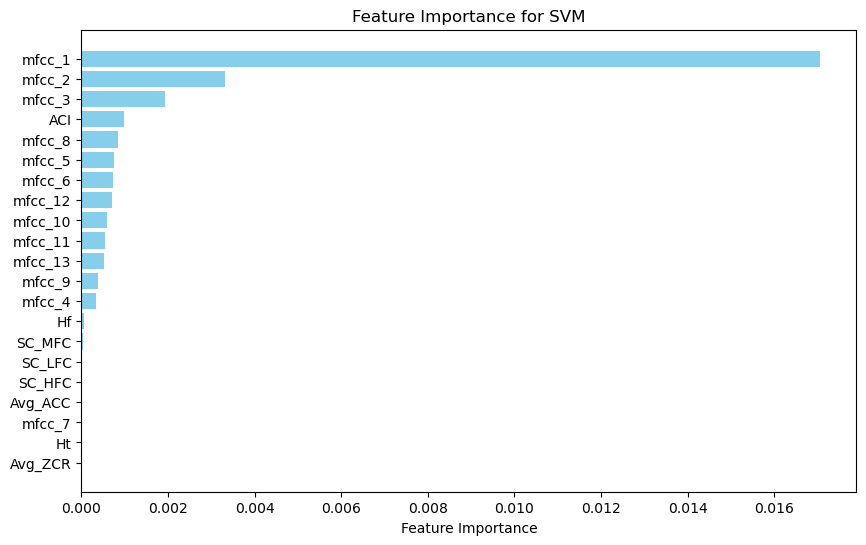

RF Accuracy: 91.51%


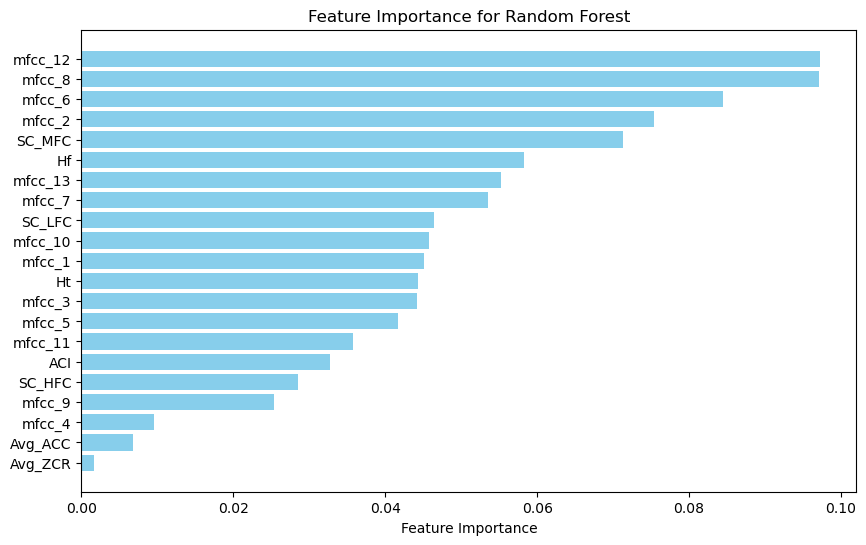

XGBoost Accuracy: 85.85%


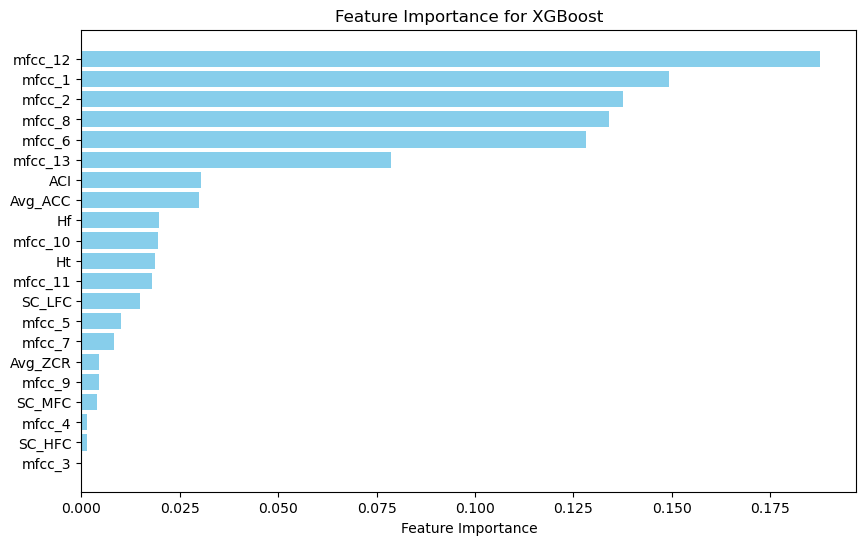

In [61]:
main()